<a href="https://colab.research.google.com/github/shell769324/NILBIE/blob/main/where_mask/MMML_what_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount your Drive and Move required Files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!tar -xvf '/content/drive/My Drive/SSCR_dataset/emnlp20_sscr/data/dataset.tar.gz'

In [4]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import h5py
import cv2
from PIL import Image
import numpy as np
import re
import collections
# from google.colab.patches import cv2_imshow

In [23]:
destination_path = 'clevr_train_what_mask.h5'
original_path = '/content/GeNeVA_datasets/data/iCLEVR/clevr_train.h5'

fs = h5py.File(original_path, 'r')
fd = h5py.File(destination_path, 'w')

def get_num_keys(destination_path):
  #returns number of datasets in h5py
  fcheck = h5py.File(destination_path, 'r')
  return len(fcheck.keys())

#get number of datasets in h5py file
batch_size_copy = get_num_keys(original_path) -2

for i in range(batch_size_copy):
  xid = f'{i:06d}'
  fs.copy(xid,fd)

fs.copy('background', fd)
fs.copy('entities', fd)
fs.close()
fd.close()


#WHAT Mask

In [24]:
def create_sample_mask(img):
  img = img[:,:, 2]
  R = len(img)
  C = len(img[0])
  # print(R, C)
  mask = [[0]*C for _ in range(R)]
  for i in range(R):
    for j in range(C):
      if img[i][j] == 255:
        mask[i][j] = 1

  return mask

In [25]:
#load image
mask_shape = {}

img_cube = cv2.imread('/content/cube.png')
img_sphere = cv2.imread('/content/sphere.png')
img_cylinder = cv2.imread('/content/cylinder.png')

# RGB_img_cube = cv2.cvtColor(img_cube, cv2.COLOR_BGR2RGB)
# RGB_img_sphere = cv2.cvtColor(img_sphere, cv2.COLOR_BGR2RGB)
# RGB_img_cylinder = cv2.cvtColor(img_cylinder, cv2.COLOR_BGR2RGB)

gen_mask_cube = create_sample_mask(img_cube)
gen_mask_sphere = create_sample_mask(img_sphere)
gen_mask_cylinder = create_sample_mask(img_cylinder)

# cv2_imshow(img_cube)
# print(img.shape)
# gen_mask = create_sample_mask(img)
# plt.imshow(gen_mask_cube)
# plt.show()
# plt.imshow(gen_mask_cylinder)
# plt.show()

# plt.imshow(gen_mask_sphere)
# plt.show()
dim = (20,20)
dim_cyl = (10,20)
# resize image
resized_sphere = cv2.resize(img_sphere, dim, interpolation = cv2.INTER_AREA)
mask_shape['sphere'] = resized_sphere[:,:,2]
RGB_img_sphere = cv2.cvtColor(resized_sphere, cv2.COLOR_BGR2RGB)

resized_cube = cv2.resize(img_cube, dim, interpolation = cv2.INTER_AREA)
mask_shape['cube'] = resized_cube[:,:,2]
RGB_img_cube = cv2.cvtColor(resized_cube, cv2.COLOR_BGR2RGB)

resized_cyl = cv2.resize(img_cylinder, dim_cyl, interpolation = cv2.INTER_AREA)
mask_shape['cylinder'] = resized_cyl[:,:,2]
RGB_img_cyl = cv2.cvtColor(resized_cyl, cv2.COLOR_BGR2RGB)

# plt.imshow(mask_shape['cube'])
# plt.show()
#Cylinder (279, 151, 3)
#Cube (262, 262, 3)
#Sphere (280, 281, 3)

In [26]:
fobjects = open("/content/GeNeVA_datasets/data/iCLEVR/objects.txt", "r").readlines()
object_list = [i.strip('\n') for i in fobjects]
print(object_list)

['cube gray', 'cube red', 'cube blue', 'cube green', 'cube brown', 'cube purple', 'cube cyan', 'cube yellow', 'sphere gray', 'sphere red', 'sphere blue', 'sphere green', 'sphere brown', 'sphere purple', 'sphere cyan', 'sphere yellow', 'cylinder gray', 'cylinder red', 'cylinder blue', 'cylinder green', 'cylinder brown', 'cylinder purple', 'cylinder cyan', 'cylinder yellow']


In [27]:
# color_mean_dict = {"red":[140, 64, 61], "yellow":[135, 127, 52],"brown":[112, 84, 46],
#                    "cyan":[54, 126, 118], "green":[50, 96, 42],"blue":[50, 70, 120],
#                    "purple":[95, 52, 113],"gray": [87, 87, 87]}

color_thres_dict = {"red":10, "yellow":10, "brown":10,
                   "cyan":10, "green":10, "blue":10,
                    "purple":50, 'gray':10}

color_mean_dict = {"gray": [87, 87, 87],
                    "red": [173, 35, 35],
                    "blue": [42, 75, 215],
                    "green": [29, 105, 20],
                    "brown": [129, 74, 25],
                    "purple": [129, 38, 192],
                    "cyan": [41, 208, 208],
                    "yellow": [255, 238, 51]}

In [28]:
def rgb2hsv(color_string):
    [red, green, blue] = color_mean_dict[color_string]
    thres = color_thres_dict[color_string]
    
    color = np.uint8([[[blue, green, red]]])
    hsv_color = cv2.cvtColor(color, cv2.COLOR_BGR2HSV)
    hue = hsv_color[0][0][0]
    
    low = max(0, hue - thres)
    high = min(360, hue + thres)
    lower_range = np.array([low, 50, 50], dtype=np.uint8)
    upper_range = np.array([high, 255, 255], dtype=np.uint8)
    
    return lower_range, upper_range

In [29]:
def color_detect(img, color="red"):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # low, high = rgb2hsv(237, 28, 36)
    low, high = rgb2hsv(color)
    # print(low, high)
    mask = cv2.inRange(hsv_img, low, high)  
    return mask, img

In [30]:
def get_next_object(objects, dicts):
  idxs = [i for i,v in enumerate(objects) if v == 1]
  for i in idxs:
    if i not in dicts:
      dicts[i] = 1
      return i

In [31]:
def sanitize_mask(orig_x, orig_y, mask):
  """
  Given a mask return centers of different color objects. 
  Ideally a mask should only have one object
  """
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # Draw contours:
  cv2.drawContours(mask, contours, 0, (0, 255, 0), 2)

  # Calculate image moments of the detected contour
  
  num_objects = (len(contours))
  # Print center (debugging):

  #threshold
  threshold = 3

  center_list = []
  # print(num_objects)
  if num_objects > 1:
    for item in range(num_objects):
      M = cv2.moments(contours[item])
      try:
        center_x = round(M['m10'] / M['m00'])
        center_y = round(M['m01'] / M['m00'])
                        
        # print(f"center X : '{center_x}'")
        # print(f"center Y : '{center_y}'")
        center_list.append([center_y , center_x ])
      except:
        pass

  # initialize retmask
  retmask = mask
  # print(orig_x, orig_y)
  # print(center_list)

  if num_objects > 1:
    
    for x, y in center_list:
      # print(mask[x][y])
      if orig_x - threshold <= x <= orig_x + threshold and orig_y - threshold <= y <= orig_y + threshold:
        pass
      else:
        # print('DFS Removal Called', x, y)
        # print(mask[x][y])
        # rr = len(mask)
        # cc = len(mask[0])
        # for i in range(rr):
        #   for j in range(cc):
        #     if mask[i][j] == 255: print(i,j)
        def dfs_removal(px , py, mask):
            R = len(mask)
            C = len(mask[0])
            if mask[px][py ] != 255: 
              return
            mask[px][py] = 0
            # print(mask[px - 1][py ],mask[px + 1][py ], mask[px][py - 1] , mask[px][py + 1])
            if 0 <= px - 1 and mask[px - 1][py ] == 255:  dfs_removal(px - 1 , py , mask)
            if  px + 1 < R and mask[px + 1][py ] == 255:  dfs_removal(px + 1 , py , mask)
            if 0 <= py - 1  and mask[px][py - 1] == 255:  dfs_removal(px, py -1 , mask)
            if py + 1 < C and mask[px][py + 1] == 255:  dfs_removal(px, py + 1 , mask)

        dfs_removal(x,y, mask)

  return retmask


In [32]:
def gray_region(x,y,shape,original_mask):
  original_mask = original_mask
  # print(original_mask.shape)

  overlay = mask_shape[shape]
  x_offset=50
  y_offset=30
  original_mask[y_offset:y_offset + overlay.shape[0], x_offset:x_offset+ overlay.shape[1]] = overlay

  return original_mask


In [57]:
fobjects = open("/content/GeNeVA_datasets/data/iCLEVR/objects.txt", "r").readlines()
object_list = [i.strip('\n') for i in fobjects]
print(object_list)

['cube gray', 'cube red', 'cube blue', 'cube green', 'cube brown', 'cube purple', 'cube cyan', 'cube yellow', 'sphere gray', 'sphere red', 'sphere blue', 'sphere green', 'sphere brown', 'sphere purple', 'sphere cyan', 'sphere yellow', 'cylinder gray', 'cylinder red', 'cylinder blue', 'cylinder green', 'cylinder brown', 'cylinder purple', 'cylinder cyan', 'cylinder yellow']


In [33]:
fdest = h5py.File(destination_path, 'r+')
for i in range(batch_size_copy):
  xid = f'{i:06d}'
  print(xid,'/', batch_size_copy)

  txt_values = fdest[xid]['text'].value.split(',')
  # print(fnew[xid].keys())
  # print(fnew[xid]['images'])
  # print(fnew[xid]['coords'])
  object_vals = fdest[xid]['objects']
  coords_vals = fdest[xid]['coords']
  object_dict = {}
  images = fdest[xid]['images'] 
  what_mask = []
  for i in range(5):
    # image = cv2.imread(images[i])
    image_resized = images[i] 
    # cv2_imshow(image_resized)
    object_added = get_next_object(object_vals[i], object_dict)
    # print(object_list[object_added])
    color_added = object_list[object_added].split(' ')[-1]
    shape_added = object_list[object_added].split(' ')[0]
    # get shape centre
    x_coord, y_coord, _ = coords_vals[i][object_added]
    mask, img = color_detect(image_resized, color_added)
    if color_added != 'gray':
      # print(mask[int(y_coord)][int(x_coord)])
      mask = sanitize_mask(y_coord, x_coord, mask)
    elif color_added == 'gray':
      mask = np.array([[0]*128 for _ in range(128)])
      mask = gray_region(y_coord,x_coord, shape_added, mask)
    what_mask.append(mask)

  fdest[xid].create_dataset('what', data = np.array(what_mask))  
    # plt.imshow(mask)
    # plt.show()
  #   break
  # break

fdest.close()

000000 / 6003
000001 / 6003
000002 / 6003
000003 / 6003
000004 / 6003
000005 / 6003
000006 / 6003
000007 / 6003
000008 / 6003
000009 / 6003
000010 / 6003
000011 / 6003
000012 / 6003
000013 / 6003
000014 / 6003
000015 / 6003
000016 / 6003
000017 / 6003
000018 / 6003
000019 / 6003


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


Streaming output truncated to the last 5000 lines.
001003 / 6003
001004 / 6003
001005 / 6003
001006 / 6003
001007 / 6003
001008 / 6003
001009 / 6003
001010 / 6003
001011 / 6003
001012 / 6003
001013 / 6003
001014 / 6003
001015 / 6003
001016 / 6003
001017 / 6003
001018 / 6003
001019 / 6003
001020 / 6003
001021 / 6003
001022 / 6003
001023 / 6003
001024 / 6003
001025 / 6003
001026 / 6003
001027 / 6003
001028 / 6003
001029 / 6003
001030 / 6003
001031 / 6003
001032 / 6003
001033 / 6003
001034 / 6003
001035 / 6003
001036 / 6003
001037 / 6003
001038 / 6003
001039 / 6003
001040 / 6003
001041 / 6003
001042 / 6003
001043 / 6003
001044 / 6003
001045 / 6003
001046 / 6003
001047 / 6003
001048 / 6003
001049 / 6003
001050 / 6003
001051 / 6003
001052 / 6003
001053 / 6003
001054 / 6003
001055 / 6003
001056 / 6003
001057 / 6003
001058 / 6003
001059 / 6003
001060 / 6003
001061 / 6003
001062 / 6003
001063 / 6003
001064 / 6003
001065 / 6003
001066 / 6003
001067 / 6003
001068 / 6003
001069 / 6003
001070 / 60

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


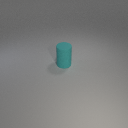

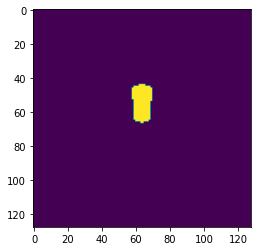

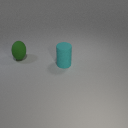

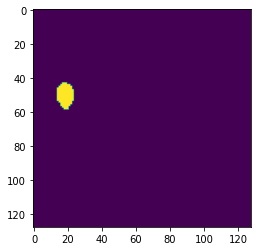

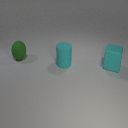

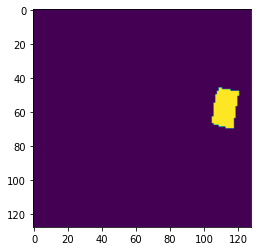

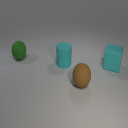

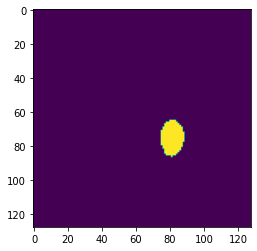

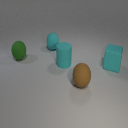

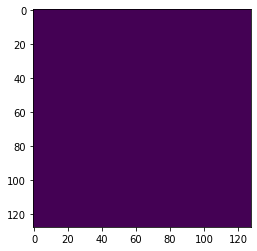

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


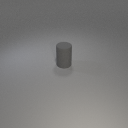

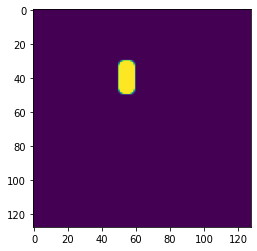

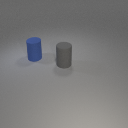

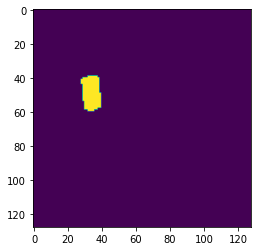

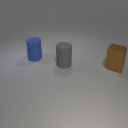

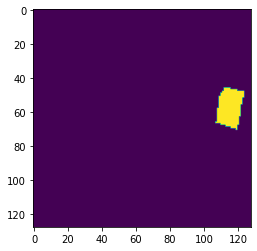

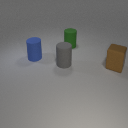

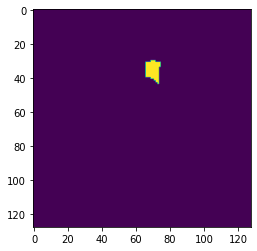

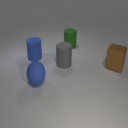

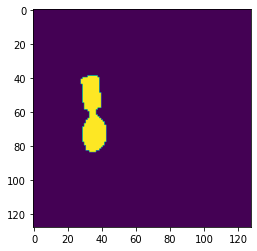

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


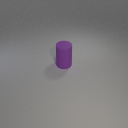

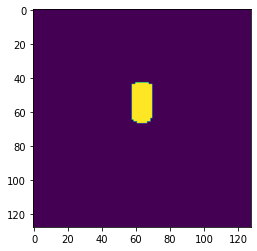

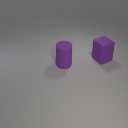

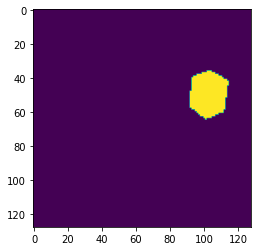

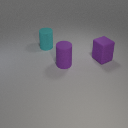

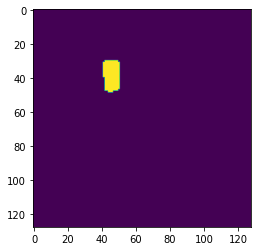

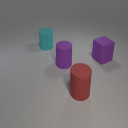

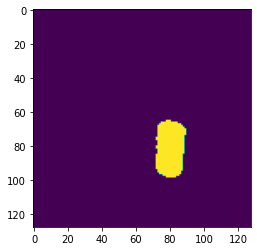

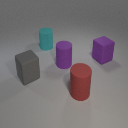

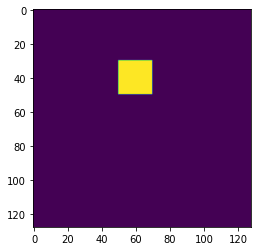

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


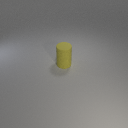

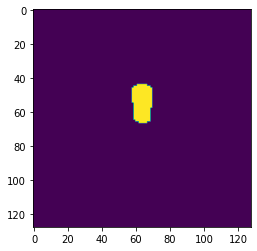

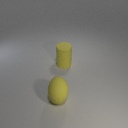

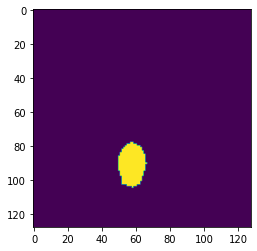

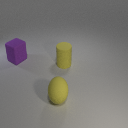

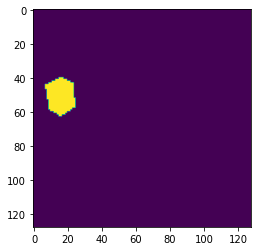

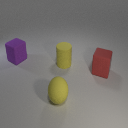

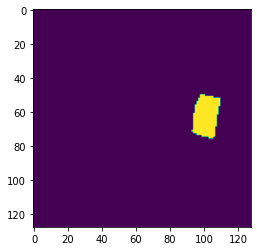

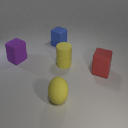

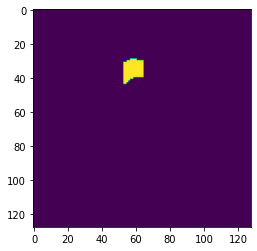

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


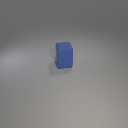

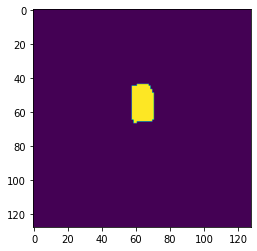

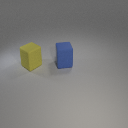

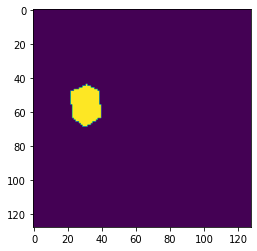

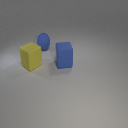

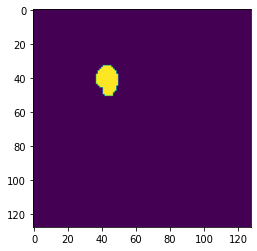

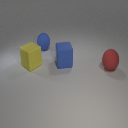

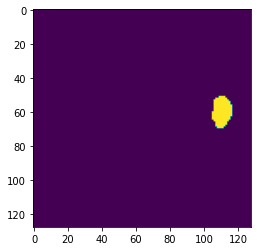

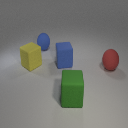

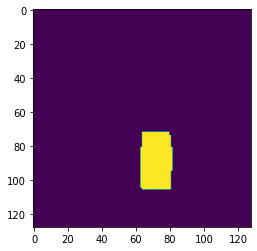

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


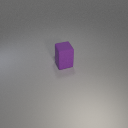

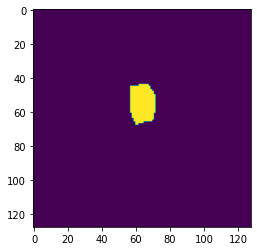

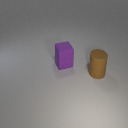

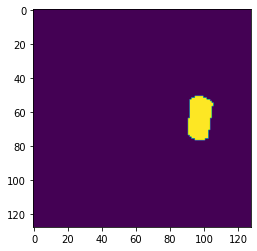

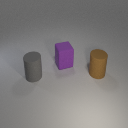

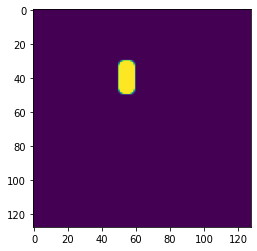

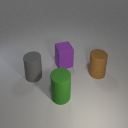

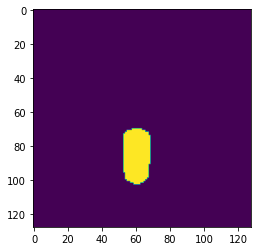

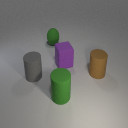

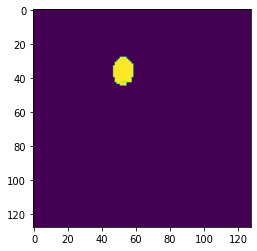

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


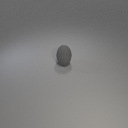

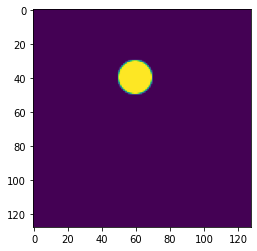

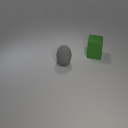

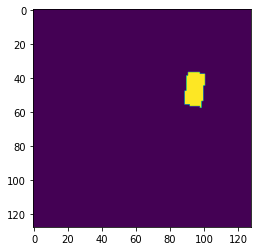

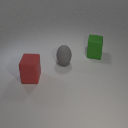

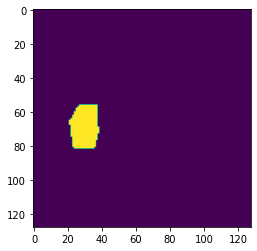

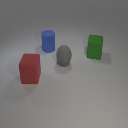

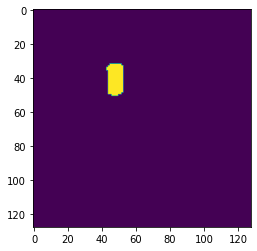

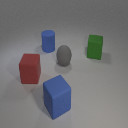

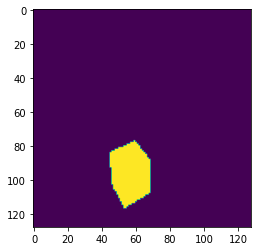

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


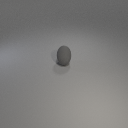

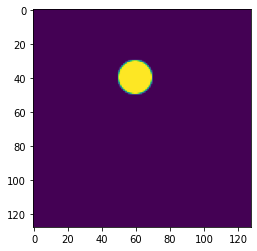

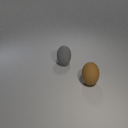

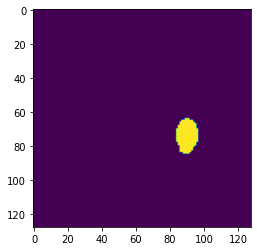

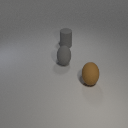

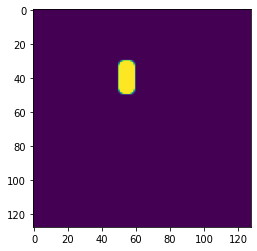

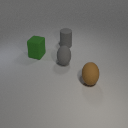

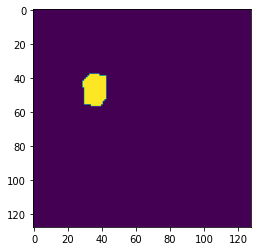

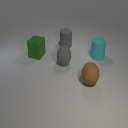

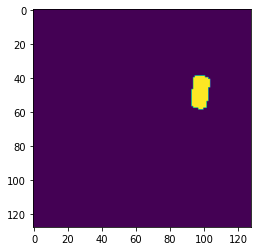

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


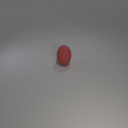

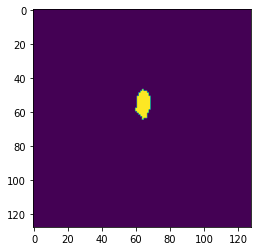

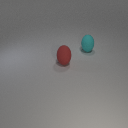

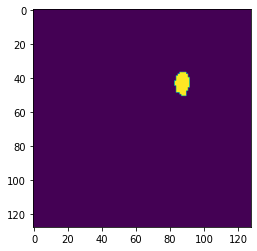

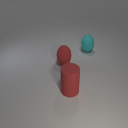

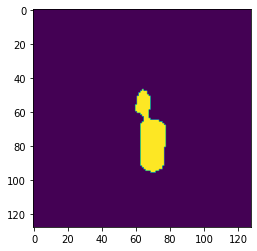

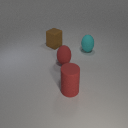

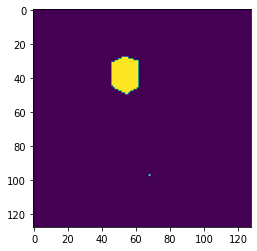

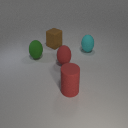

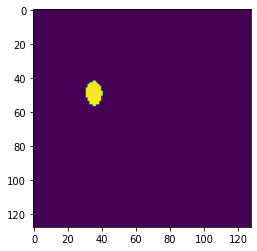

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


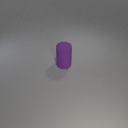

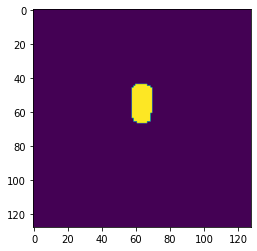

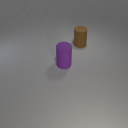

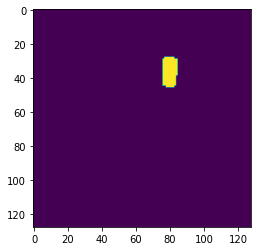

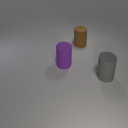

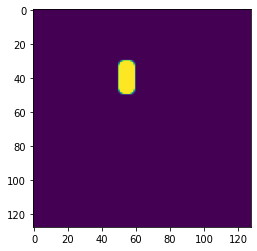

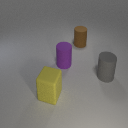

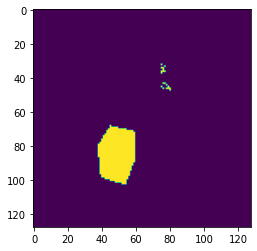

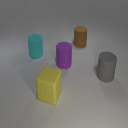

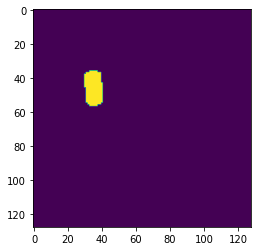

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


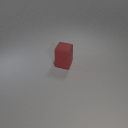

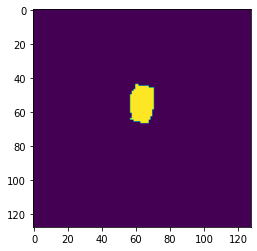

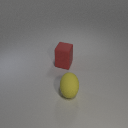

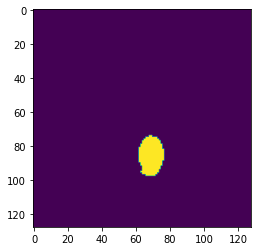

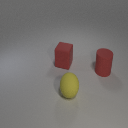

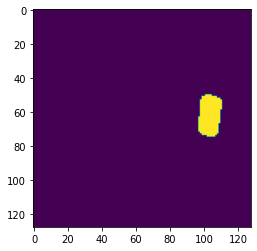

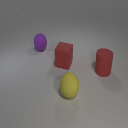

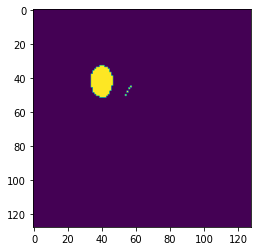

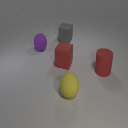

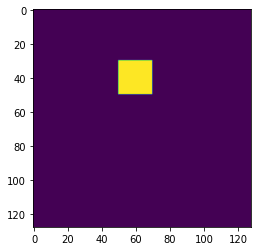

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


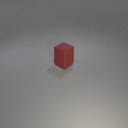

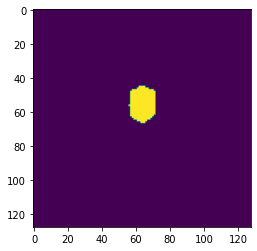

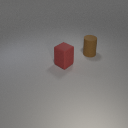

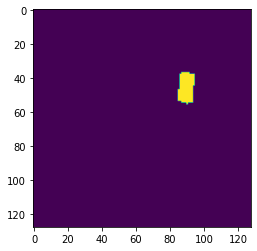

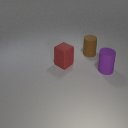

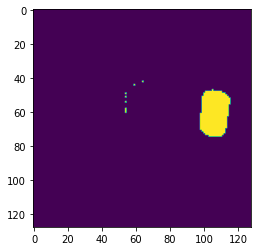

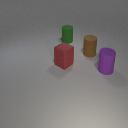

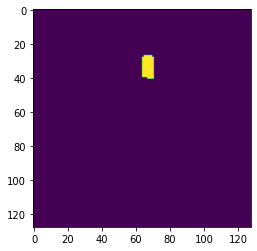

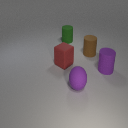

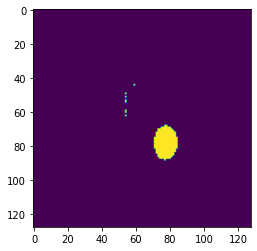

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


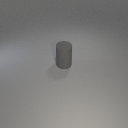

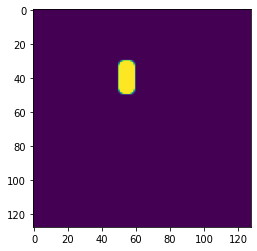

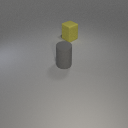

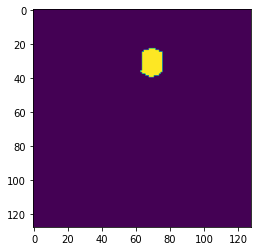

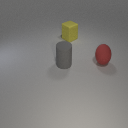

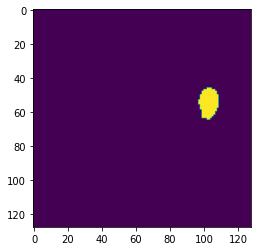

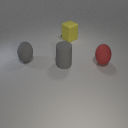

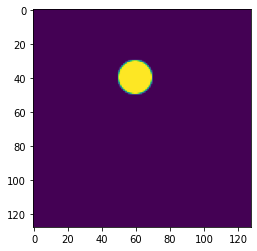

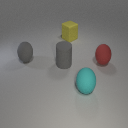

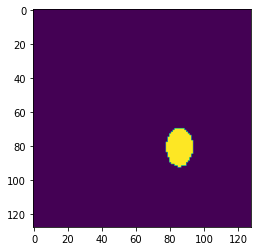

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


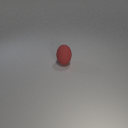

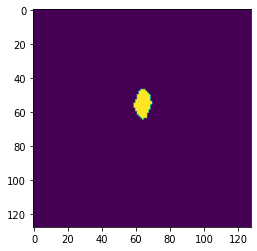

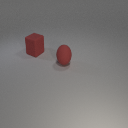

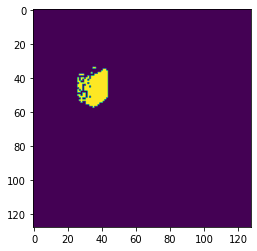

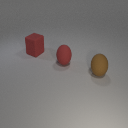

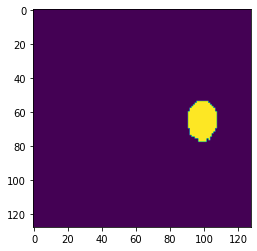

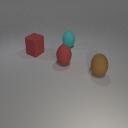

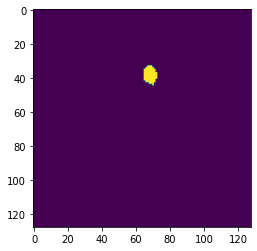

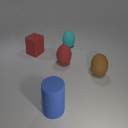

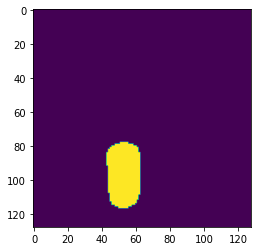

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


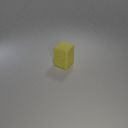

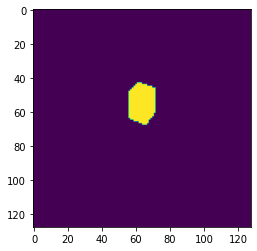

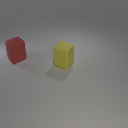

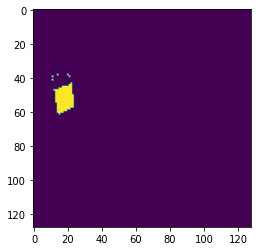

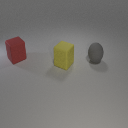

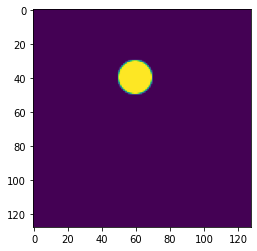

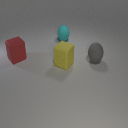

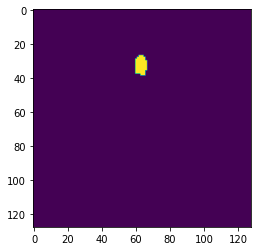

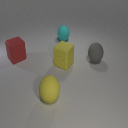

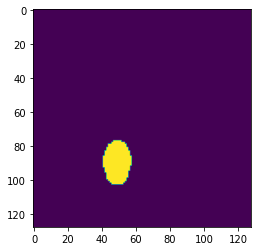

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


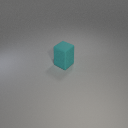

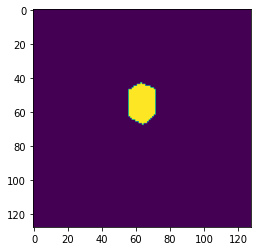

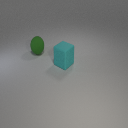

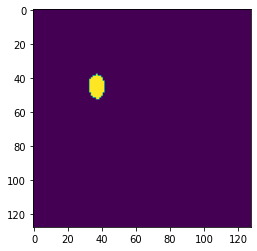

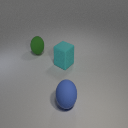

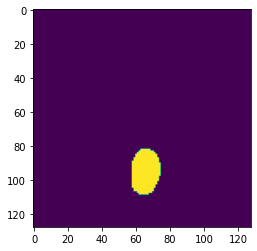

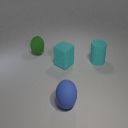

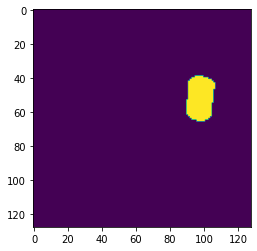

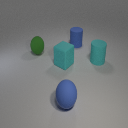

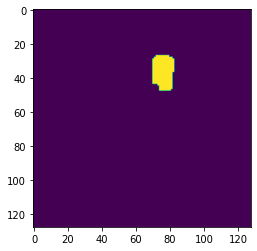

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


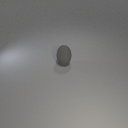

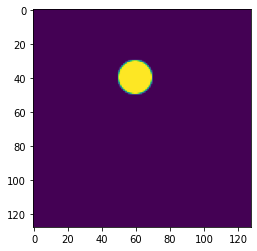

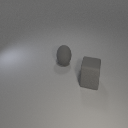

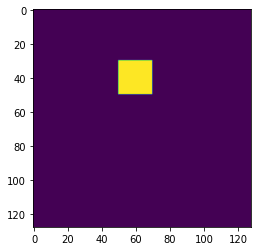

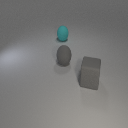

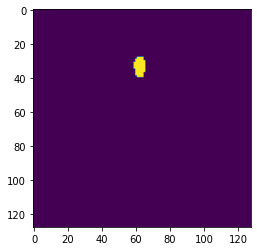

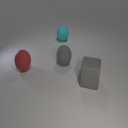

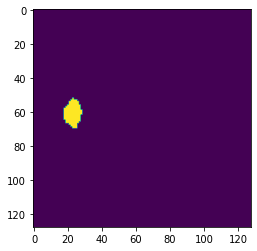

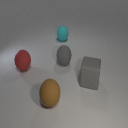

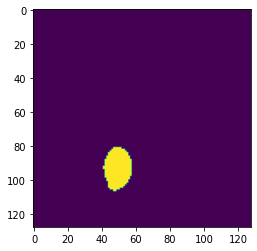

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


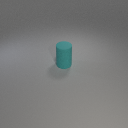

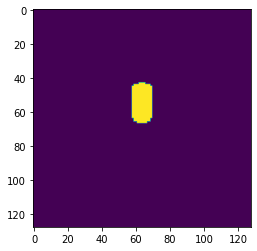

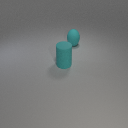

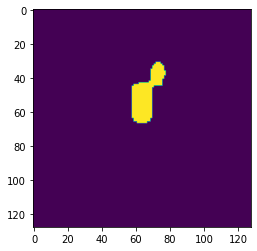

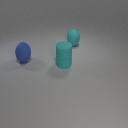

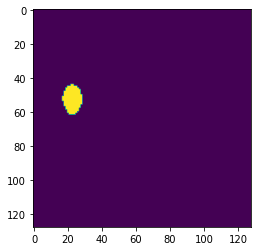

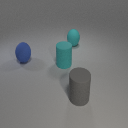

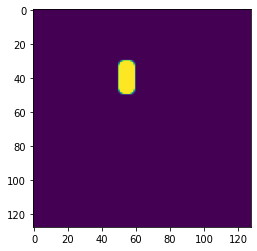

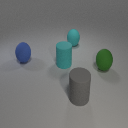

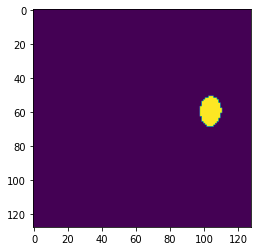

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


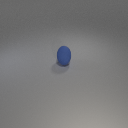

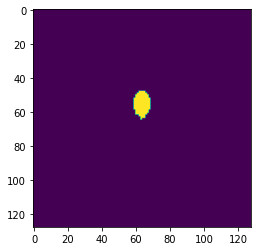

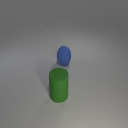

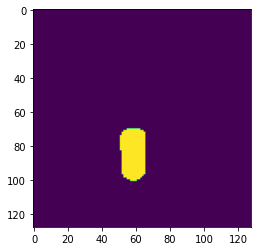

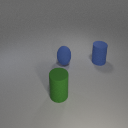

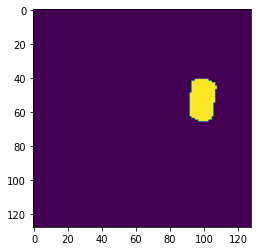

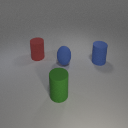

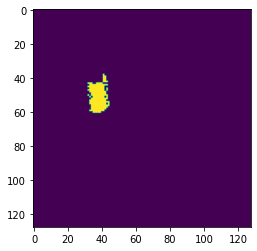

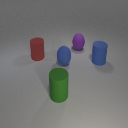

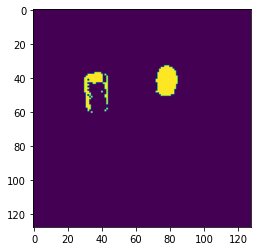

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


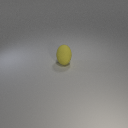

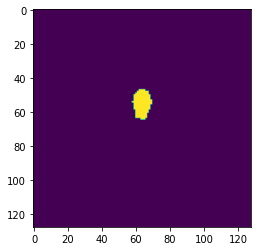

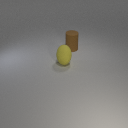

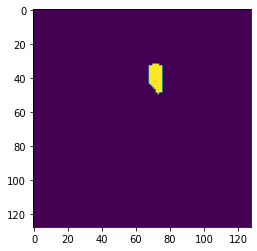

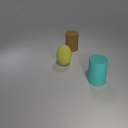

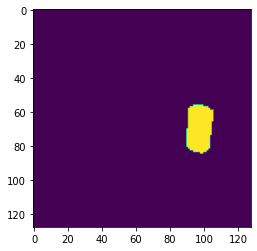

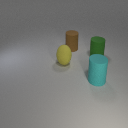

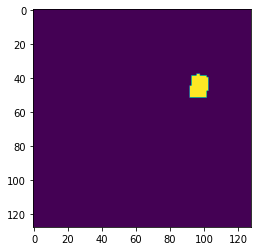

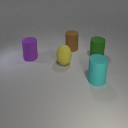

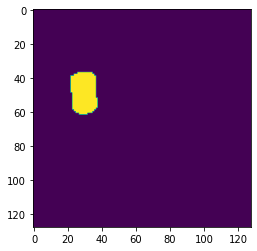

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


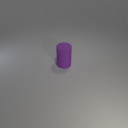

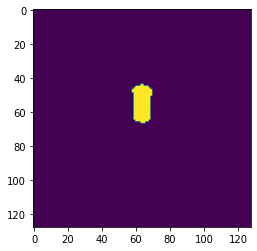

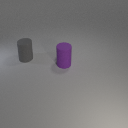

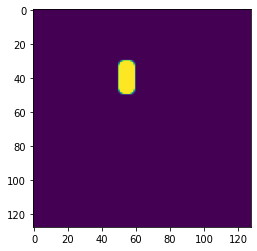

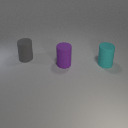

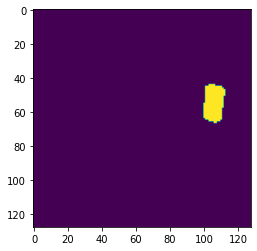

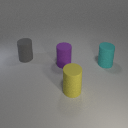

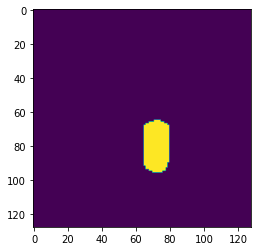

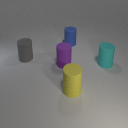

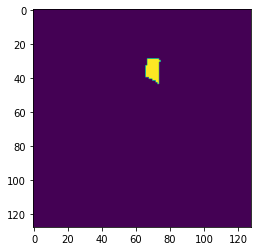

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


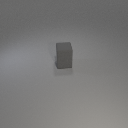

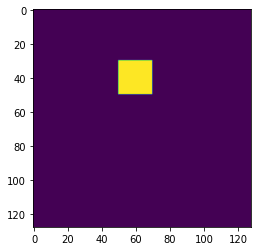

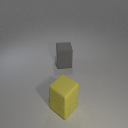

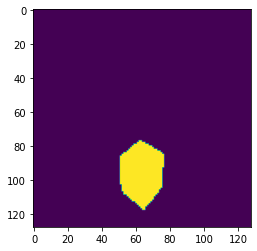

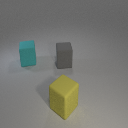

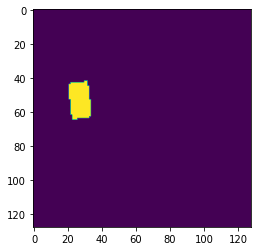

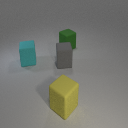

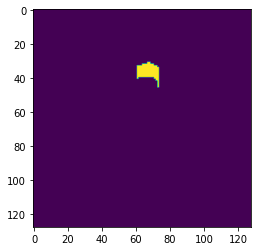

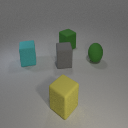

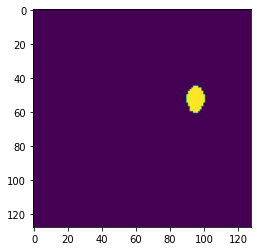

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


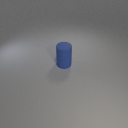

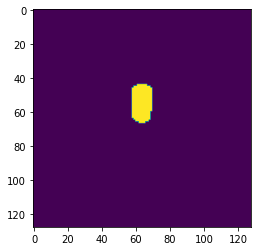

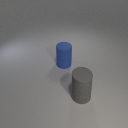

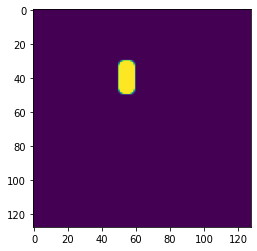

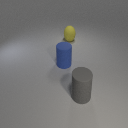

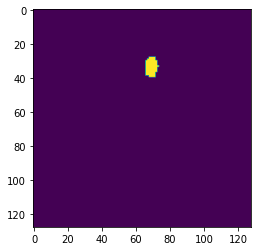

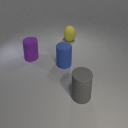

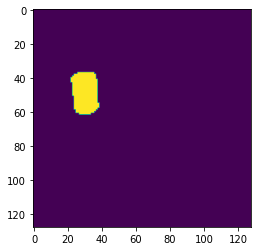

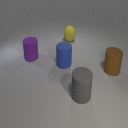

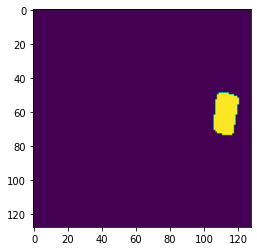

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


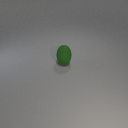

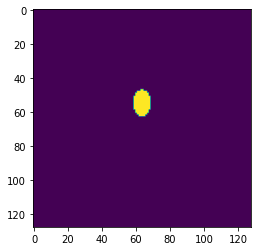

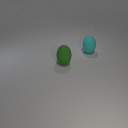

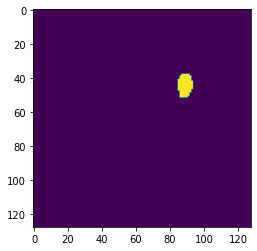

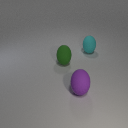

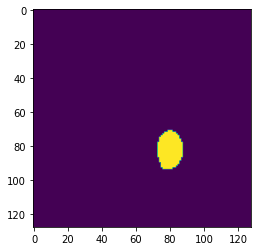

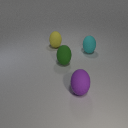

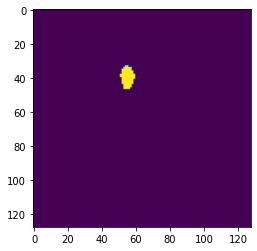

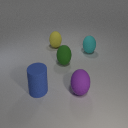

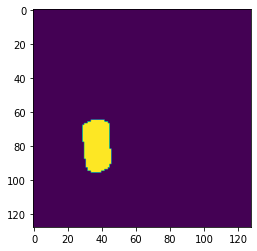

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


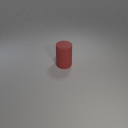

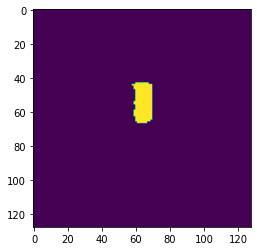

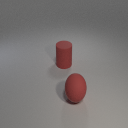

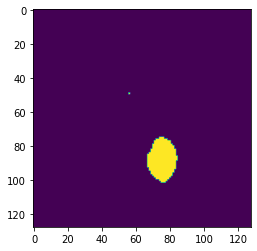

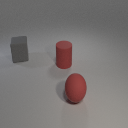

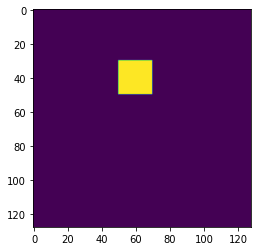

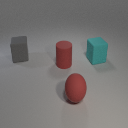

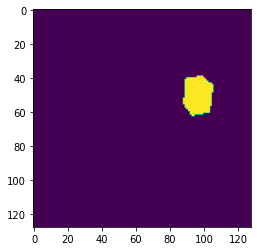

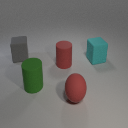

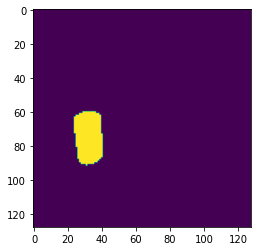

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


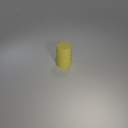

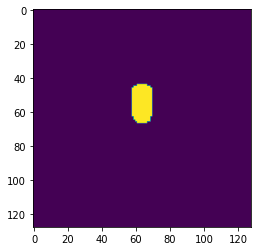

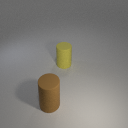

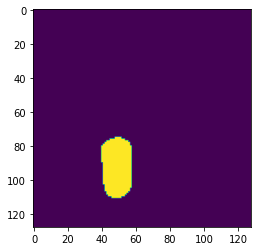

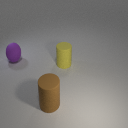

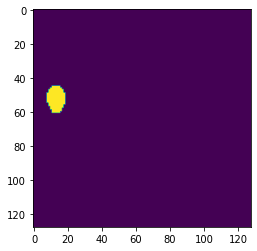

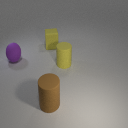

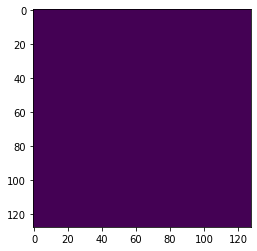

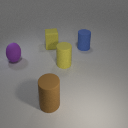

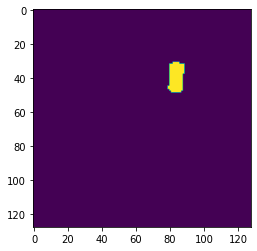

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


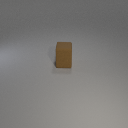

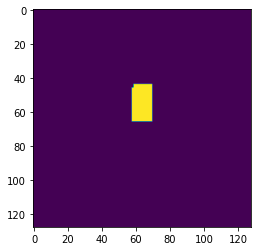

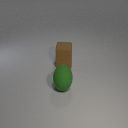

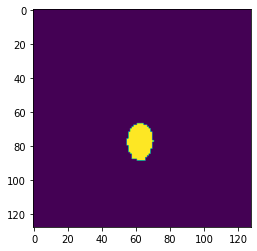

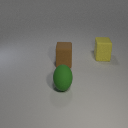

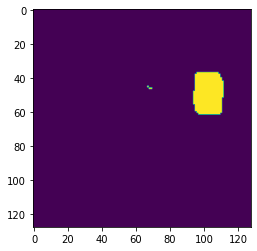

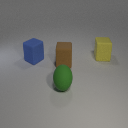

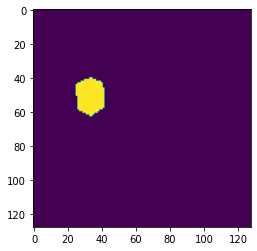

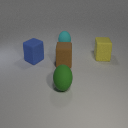

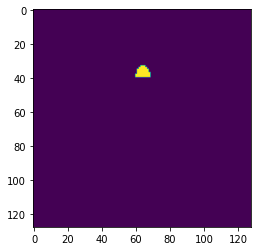

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


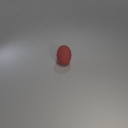

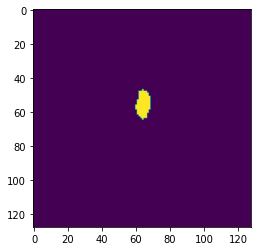

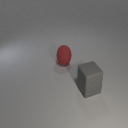

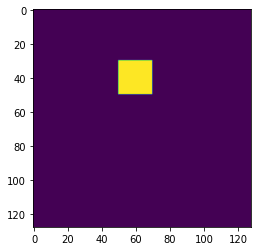

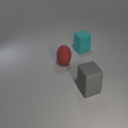

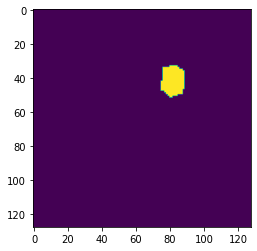

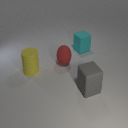

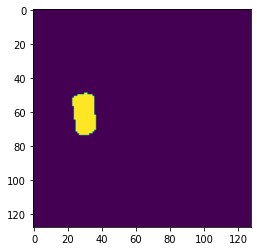

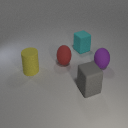

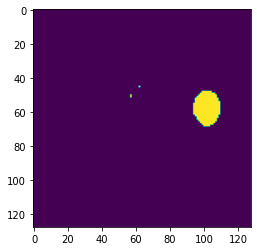

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


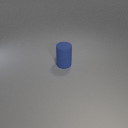

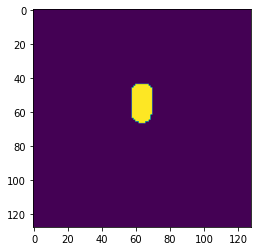

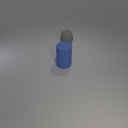

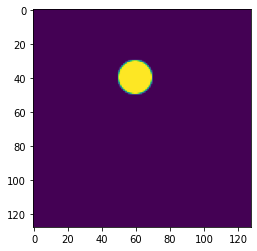

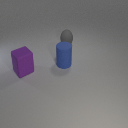

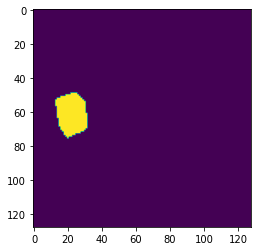

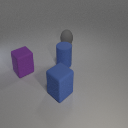

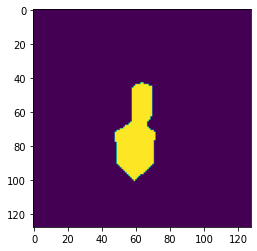

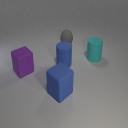

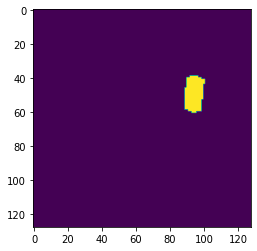

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "<i8">


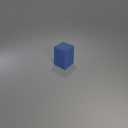

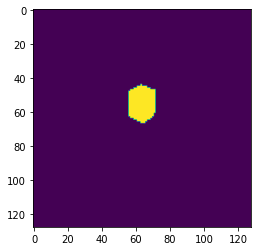

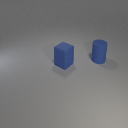

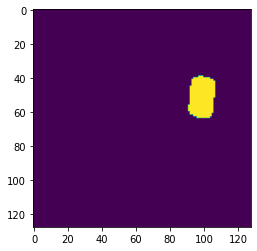

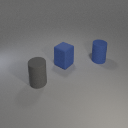

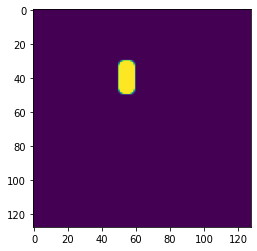

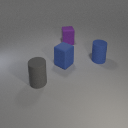

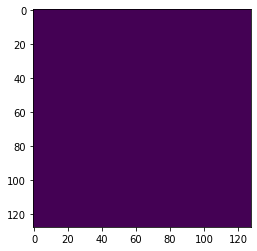

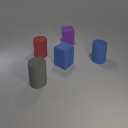

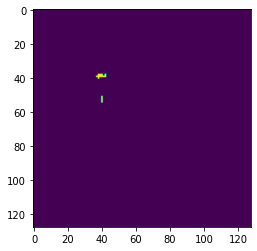

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


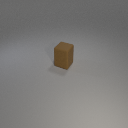

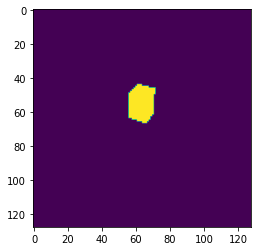

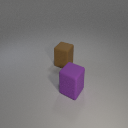

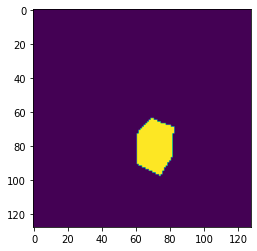

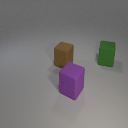

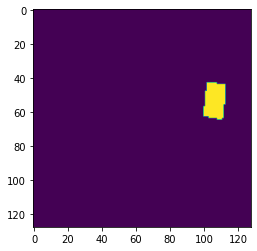

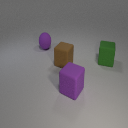

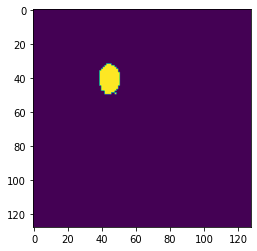

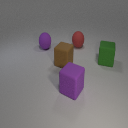

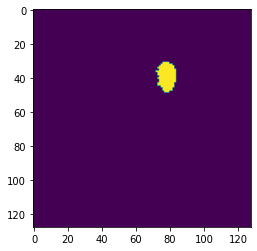

<KeysViewHDF5 ['coords', 'images', 'objects', 'scene_id', 'text', 'what']>
<HDF5 dataset "what": shape (5, 128, 128), type "|u1">


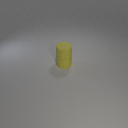

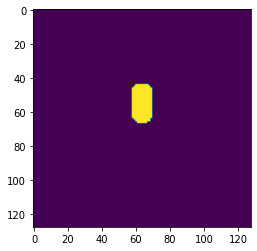

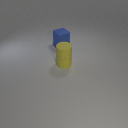

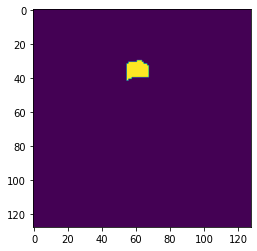

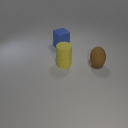

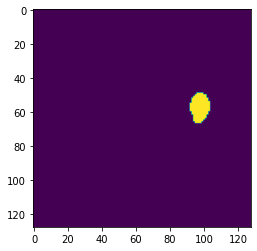

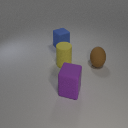

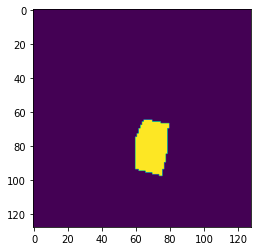

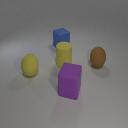

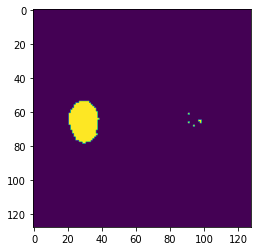

In [36]:
import h5py
check_path = '/content/clevr_train_what_mask.h5'
fcheck = h5py.File(check_path, 'r')
check_nums = 32
from google.colab.patches import cv2_imshow
for i in range(check_nums):
  xid = f'{i:06d}'
  print(fcheck[xid].keys())
  print(fcheck[xid]['what'])
  for i in range(5):
    actual_img = fcheck[xid]['images'][i]
    cv2_imshow(actual_img)
    mask_grid = fcheck[xid]['what'][i]
    plt.imshow(mask_grid)
    plt.show()

# WHERE Mask

In [193]:
destination_path = 'clevr_train_what_mask.h5'
original_path = '/content/GeNeVA_datasets/data/iCLEVR/clevr_train.h5'

fs = h5py.File(original_path, 'r')
fd = h5py.File(destination_path, 'w')

#get number of datasets in h5py file
batch_size_copy = get_num_keys(original_path) -2

for i in range(batch_size_copy):
  xid = f'{i:06d}'
  fs.copy(xid,fd)

fs.copy('background', fd)
fs.copy('entities', fd)
fs.close()
fd.close()

In [194]:
def get_dict(dicts, coords, objects):
  """
  return the coordinate of the newly added object
  """
  o_idx = [i for i, x in enumerate(objects) if x == 1]
  # print(o_idx)
  # print(dicts)
  for idx in o_idx:
    if idx not in dicts:
      dicts[idx] = coords[idx]
      return coords[idx]

In [195]:
def get_next_object(objects, dicts):
  idxs = [i for i,v in enumerate(objects) if v == 1]
  for i in idxs:
    if i not in dicts:
      dicts[i] = 1
      return i

In [196]:
fobjects = open("/content/GeNeVA_datasets/data/iCLEVR/objects.txt", "r").readlines()
object_list = [i.strip('\n') for i in fobjects]
list_color_shape = [val.split(' ')[1]+' '+val.split(' ')[0] for val in object_list]
print(list_color_shape)

['gray cube', 'red cube', 'blue cube', 'green cube', 'brown cube', 'purple cube', 'cyan cube', 'yellow cube', 'gray sphere', 'red sphere', 'blue sphere', 'green sphere', 'brown sphere', 'purple sphere', 'cyan sphere', 'yellow sphere', 'gray cylinder', 'red cylinder', 'blue cylinder', 'green cylinder', 'brown cylinder', 'purple cylinder', 'cyan cylinder', 'yellow cylinder']


In [197]:
def create_grid(x, y, startx, endx, starty, endy):  
  grid = [[0]*x for _ in range(y)]
  for i in range(startx, endx):
    for j in range(starty , endy):
      grid[j][i]= 1
  return grid

In [198]:
mask_shape = 128
def tune_mask(ret):
  masks = []
  for item in ret:
    x, y, bf, lr = item
    # print(x, y, bf, lr)
    # x, y, startx, endx, starty, endy
    if bf == -1 and lr == -1:
      startx, endx, starty, endy = 0, x, 0, y
    elif bf == 1 and lr == -1:
      startx, endx, starty, endy = 0, x, y, mask_shape
    elif bf == -1 and lr == 1:
      startx, endx, starty, endy = x,mask_shape, 0,y
    elif bf == 1 and lr == 1:
      startx, endx, starty, endy = x, mask_shape, y, mask_shape
    # print(startx, endx, starty, endy)
    mask = create_grid(mask_shape, mask_shape, int(startx), int(endx), int(starty), int(endy))
    # plt.imshow(mask)
    # plt.show()
    masks.append(mask)

  if len(masks)==1:
    return masks[0]
  # print(len(masks))
  # print(masks)
  final_mask = [[0]*mask_shape for _ in range(mask_shape)]
  for i in range(mask_shape):
    for j in range(mask_shape):
      if masks[0][i][j] == masks[1][i][j]==1:
        final_mask[i][j] = 1

  return final_mask
  
  



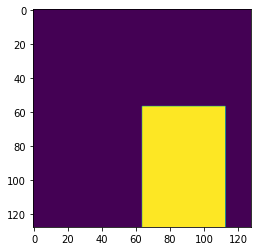

In [199]:
#  Add a brown sphere in front of it on the left and in front of the cyan cylinder on the right
ret = [[113.2, 57.6, 1, -1], [64.0, 54.93333333333333, 1, 1]]
final_mask = tune_mask(ret)
plt.imshow(final_mask)
plt.show()

In [200]:
def get_objects_xy(ctext,object_track_list,last_object,object_added_color_shape):
  ret = []
  lr,bf = 1,1
  if 'and' in ctext:
    first_, secd_ = ctext.split('and')
    # print(first_, secd_)

    for lang in [first_, secd_]:
      if 'right' in lang:
        lr = 1
      elif 'left' in lang:
        lr = -1
      if 'front' in lang:
        bf = 1
      elif 'behind' in lang:
        bf = -1
      if 'it' not in lang:
        for object_name in list_color_shape:
          if object_name in lang and object_name != object_added_color_shape:
            ocolor, oshape  = object_name.split(' ')

            # print(oshape , ocolor,object_track_list[ocolor,oshape] )
            ox, oy = object_track_list[ocolor, oshape]
            ret.append([ox, oy, bf, lr])


      elif 'it' in lang:
        itx, ity = object_track_list[last_object[0],last_object[1]]
        # print('itx, ity', itx, ity,lr,bf)
        ret.append([itx, ity, bf, lr])

  elif 'it' in ctext:
    if 'right' in ctext:
      lr = 1
    elif 'left' in ctext:
      lr = -1
    if 'front' in ctext:
      bf = 1
    elif 'behind' in ctext:
      bf = -1
    itx, ity = object_track_list[last_object[0],last_object[1]]
    # print('itx, ity', itx, ity,lr,bf)
    ret.append([itx, ity, bf, lr])


  return ret








In [201]:
fdest = h5py.File(destination_path, 'r+')
num_keys_in_destination = get_num_keys(destination_path) - 2
count = 0
object_dict = {}
mask_shape = 128
for i in (range(num_keys_in_destination)):#num_keys_in_destination
  count += 1
  print(count ,'/', num_keys_in_destination)
  xid = f'{i:06d}'
  # img_path = fdest[xid]['images']
  object_dict = {}
  where_mask = []
  object_vals = fdest[xid]['objects']
  coords_vals = fdest[xid]['coords']
  text_vals = fdest[xid]['text'].value.split(',')
  image_vals = fdest[xid]['images']
  object_track_list = {}
  last_object = ''
  what_mask = []
  for i in range(5):
    new_grid = [[0]*128 for _ in range(128)]
    ctext = text_vals[i].replace('[','').replace(']','').replace('"','')
    object_added = get_next_object(object_vals[i], object_dict)
    color_added = object_list[object_added].split(' ')[-1]
    shape_added = object_list[object_added].split(' ')[0]
    object_added_color_shape = color_added + ' ' + shape_added
    new_grid = [[1]*mask_shape for _ in range(mask_shape)]
    if i > 0:
      # print(ctext)
      ret = get_objects_xy(ctext, object_track_list,last_object,object_added_color_shape)

      # print(ret)
      new_grid = tune_mask(ret)
      # new_grid = tune_mask(l1,l2)

    what_mask.append(new_grid)
    
    # get shape centre
    x_coord, y_coord, _ = coords_vals[i][object_added]
    last_object = [ color_added, shape_added]

    # print(color_added, shape_added ,x_coord ,y_coord)
    
    object_track_list[color_added, shape_added]=[x_coord ,y_coord]
    # print(object_track_list)
    # plt.imshow(image_vals[i])
    # plt.show()
    # plt.imshow(new_grid)
    # plt.show()
    
  

    # coord_of_object = get_dict(dicts, fdest[xid]['coords'].value[i], fdest[xid]['objects'].value[i])
    # # print(coord_of_object)
    # quad = get_quadrant(coord_of_object)
    # # print(quad, 'QUAD')
    # if i > 0:
    #   mask_grid = grid_dicts[quad]
    # else:
    #   mask_grid = grid_dicts[0]
    # where_mask.append(mask_grid)
    # plt.imshow(mask_grid)
    # plt.show()
    # cv2_imshow(img_path.value[i])
  fdest[xid].create_dataset('what', data = np.array(what_mask))

fdest.close()

1 / 6003
2 / 6003
3 / 6003
4 / 6003
5 / 6003
6 / 6003
7 / 6003
8 / 6003
9 / 6003


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  from ipykernel import kernelapp as app


Streaming output truncated to the last 5000 lines.
1004 / 6003
1005 / 6003
1006 / 6003
1007 / 6003
1008 / 6003
1009 / 6003
1010 / 6003
1011 / 6003
1012 / 6003
1013 / 6003
1014 / 6003
1015 / 6003
1016 / 6003
1017 / 6003
1018 / 6003
1019 / 6003
1020 / 6003
1021 / 6003
1022 / 6003
1023 / 6003
1024 / 6003
1025 / 6003
1026 / 6003
1027 / 6003
1028 / 6003
1029 / 6003
1030 / 6003
1031 / 6003
1032 / 6003
1033 / 6003
1034 / 6003
1035 / 6003
1036 / 6003
1037 / 6003
1038 / 6003
1039 / 6003
1040 / 6003
1041 / 6003
1042 / 6003
1043 / 6003
1044 / 6003
1045 / 6003
1046 / 6003
1047 / 6003
1048 / 6003
1049 / 6003
1050 / 6003
1051 / 6003
1052 / 6003
1053 / 6003
1054 / 6003
1055 / 6003
1056 / 6003
1057 / 6003
1058 / 6003
1059 / 6003
1060 / 6003
1061 / 6003
1062 / 6003
1063 / 6003
1064 / 6003
1065 / 6003
1066 / 6003
1067 / 6003
1068 / 6003
1069 / 6003
1070 / 6003
1071 / 6003
1072 / 6003
1073 / 6003
1074 / 6003
1075 / 6003
1076 / 6003
1077 / 6003
1078 / 6003
1079 / 6003
1080 / 6003
1081 / 6003
1082 / 6003
1

["Add a cyan cylinder at the center"


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if sys.path[0] == '':


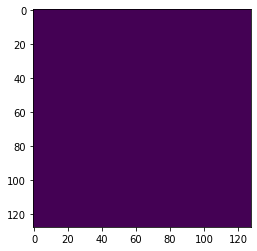

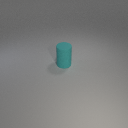

 "Add a green sphere behind it on the left"


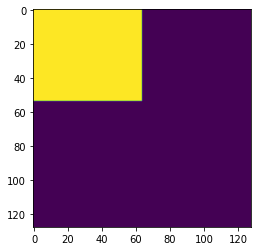

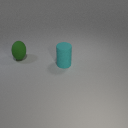

 "Add a cyan cube in front of it on the right and in front of the cyan cylinder on the right"


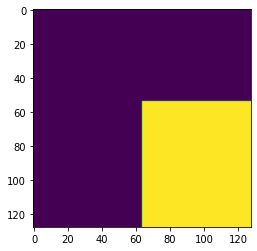

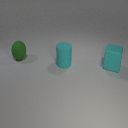

 "Add a brown sphere in front of it on the left and in front of the cyan cylinder on the right"


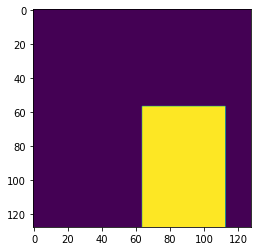

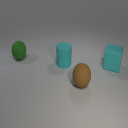

 "Add a cyan sphere behind the green sphere on the right and behind the cyan cylinder on the left"]


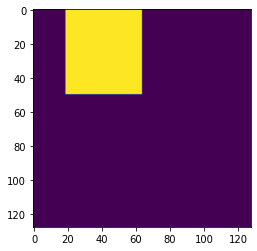

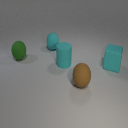

["Add a gray cylinder at the center"


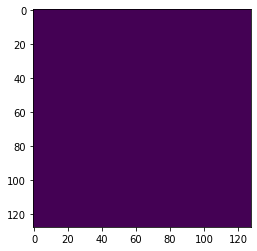

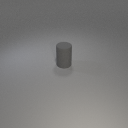

 "Add a blue cylinder behind it on the left"


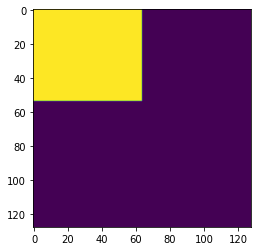

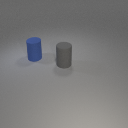

 "Add a brown cube in front of it on the right and in front of the gray cylinder on the right"


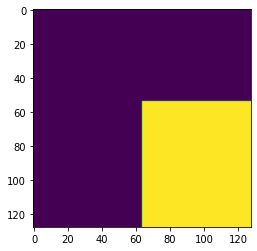

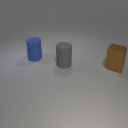

 "Add a green cylinder behind the blue cylinder on the right and behind the gray cylinder on the right"


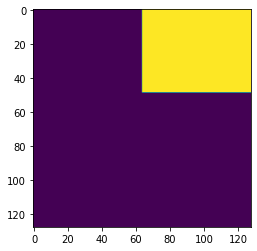

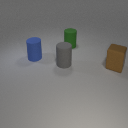

 "Add a blue sphere in front of the brown cube on the left and in front of the gray cylinder on the left"]


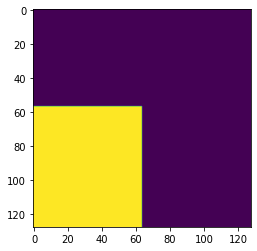

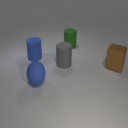

["Add a purple cylinder at the center"


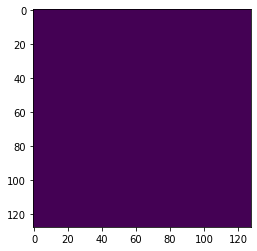

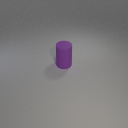

 "Add a purple cube behind it on the right"


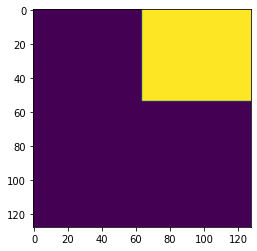

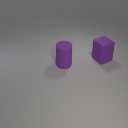

 "Add a cyan cylinder behind it on the left and behind the purple cylinder on the left"


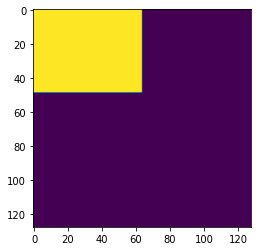

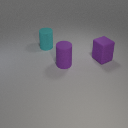

 "Add a red cylinder in front of it on the right and in front of the purple cylinder on the right"


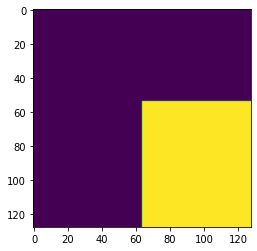

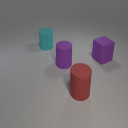

 "Add a gray cube in front of the cyan cylinder on the left and in front of the purple cube on the left"]


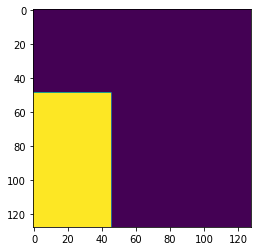

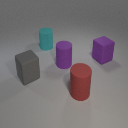

In [206]:
#check the mask where
import h5py

check_path = '/content/clevr_train_what_mask.h5'
fcheck = h5py.File(check_path, 'r')

check_nums = 3

for i in range(check_nums):
  xid = f'{i:06d}'
  image_vals = fcheck[xid]['images']
  text_vals = fcheck[xid]['text'].value.split(',')
  # print(fcheck[xid].keys())
  # print(fcheck[xid]['where'])
  for i in range(5):
    print(text_vals[i])
    mask_grid = fcheck[xid]['what'][i]
    plt.imshow(mask_grid)
    plt.show()
    cv2_imshow(image_vals[i])



fcheck.close()